
# Data

### Ultimate 25k+ Matches Football Database

<div><img width="400px" height="auto" src="https://images.unsplash.com/photo-1489944440615-453fc2b6a9a9?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1482&q=80" /></div>

Imagine that you are a data scientist working in a sports betting company.
The business executives in your company after some initial analysis (they watched this video [Understanding European Soccer in Four Simple Steps: A Guide For Americans](https://www.youtube.com/watch?v=FZ4i3KX2CW4)) identified betting on soccer (European football) as an potential new business opportunity.
The problem is that your company doesn't know a lot about soccer (European football).
Your manager asked you to analyse this dataset and see if you can provide anything that could give us a competitive advantage in the attempt to start strong in the new endevor.


The link to the [Kaggle dataset is here](https://www.kaggle.com/prajitdatta/ultimate-25k-matches-football-database-european).



## Introduction

The main purpose of this work is to study this dataset and highlight some unique features that can lead to more successful placement of a new betting company. In addition, we need to create forecasts that would allow us to more accurately predict the outcome of the match.

I've been working on the difference between the two leagues to get more specific data. I think this way of studying this data set is more useful, as we will observe it in more detail, and this will allow us to build a more successful betting company in this region.

## 1 Setup

In [1]:
import pandas as pd
import numpy as np
import statsmodels.stats.api as sms
import seaborn as sns
import dill
import sqlite3
import matplotlib.pyplot as plt
import io
from scipy.stats import ttest_ind
import plotly.express as px
import plotly.graph_objects as go
from google.colab import drive
from google.colab import files
import xml.etree.ElementTree as ET
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import (
    LinearRegression,
    ElasticNet,
    LogisticRegression,
)
from sklearn.metrics import classification_report, plot_confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    RobustScaler,
    MaxAbsScaler,
    StandardScaler,
    PolynomialFeatures,
)
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE


drive.mount("/content/drive")

conn = sqlite3.connect("/content/drive/MyDrive/database.sqlite")

uploaded = files.upload();

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving countries.csv to countries (1).csv


In [2]:
countries_geo = pd.read_csv(io.StringIO(uploaded["countries.csv"].decode("utf-8")))
countries_geo.head()

,latitude,longitude,Country
0,41.871940,12.567380,Italy
1,55.378051,-3.435973,United Kingdom
2,46.227638,2.213749,France
3,51.165691,10.451526,Germany
4,50.503887,4.469936,Belgium


In this work, a map will be plotted, for this purpose, I will use an additional dataset: [Developers google](https://developers.google.com/public-data/docs/canonical/countries_csv)

### 1.1 Functions

In [3]:
def merging(f_df: pd.DataFrame, s_df: pd.DataFrame, l_on: list) -> pd.DataFrame:
    """
    Takes two Data Frames and a list of label names.
    Returns merged Data Frame on a given list.
    """

    to_merge = pd.merge(f_df, s_df, how="inner", on=l_on)

    return to_merge


def subplots(
    value_l: list,
    df_p: pd.DataFrame,
    x: str,
    y: str,
    hue: str,
    col_n: str,
    title_n: str,
    sub_t: str,
) -> None:
    """
    Takes Data Frame, list of label names, value for x and y axis, color name,
    title and subtitle name.
    Returns several subplots.
    """

    fig, ax = plt.subplots(2, 4, figsize=(16, 14))
    fig.suptitle(title_n, fontsize=16)
    sns.set_style("ticks")
    k = 0
    i = 0

    for seasons in range(len(value_l)):
        if seasons == 4:
            i += 1
        g = sns.barplot(
            x=x,
            y=y,
            hue=hue,
            data=df_p[df_p[col_n] == value_l[seasons]],
            ax=ax[i][k],
            palette="Pastel2",
        )
        g.set_title(value_l[seasons])
        g.legend([], [], frameon=False)
        g.tick_params(axis="x", rotation=45)
        g.set(xlabel=None)
        g.set(ylabel=None)
        plt.xlabel("")
        k += 1
        if k == 4:
            k = 0


    plt.subplots_adjust(top=0.91, bottom=0.01, hspace=0.3, wspace=0.4)
    sns.despine()
    plt.show()


def scater_1(
    df_t: pd.DataFrame, x: str, y: str, hue: str, title_p: str, p_title: str, s: int
) -> None:
    """
    Takes Data Frame, value for x and y axis, color name, value for dot size,
    title and subtitle name.
    Returns scater plot.
    """

    plt.suptitle(p_title, fontsize=16)
    sns.set_style("ticks")
    sns.scatterplot(data=df_t, x=x, y=y, hue=hue, palette="RdGy_r", s=s)
    sns.set(rc={"figure.figsize": (14, 10)})
    sns.despine()
    plt.legend(title=title_p)
    plt.subplots_adjust(top=0.92)
    plt.show()


def value_r(data_f: pd.DataFrame, row_t: str, to_r: str, rep: str) -> pd.DataFrame:
    """
    Takes Data Frame, colum name, orginal string and string whcih should be replaced.
    Returns new Data Frame with replaced string in column
    """

    data_f[row_t] = data_f[row_t].str.replace(to_r, rep)

    return data_f


def to_drop_v(df_d: pd.DataFrame, row_d: str, values_d: list) -> pd.DataFrame:
    """
    Takes Data Frame, colum name, and list of values which should be droped.
    Returns new Data Frame without deleted values.
    """

    df_d = df_d[~df_d[row_d].isin(values_d)]

    return df_d


def g_count(g_df: pd.DataFrame, g_list: list, g_col: str, n_col: str) -> pd.DataFrame:
    """
    Takes Data Frame, list of column names, name of specific column and new column name.
    Returns new Data Frame grouped items and counted how many times particular value repeated.
    """

    new_df = g_df.groupby(g_list)[g_col].count().reset_index(name=n_col)

    return new_df


def convert_to_n(data_c: pd.DataFrame, column_c: str) -> pd.DataFrame:
    """
    Takes Data Frame and colum name.
    Returns new Data Frame with object changed to the float.
    """

    data_c[column_c] = data_c[column_c].astype(float)
    return data_c


def hist_plot(wine_data: pd.DataFrame, colors: str) -> None:
    """
    Takes Data Frame and color name.
    Returns the specified number of subplots.
    """

    fig, ax = plt.subplots(7, 4, figsize=(20, 16))
    sns.set_style("ticks")
    sns.set_palette(colors)
    sns.despine()
    for i in range(28):
        j = i // 4
        k = i % 4
        sns.histplot(x=cols[i], data=wine_data, ax=ax[j][k], kde=True)
        sns.despine()

    plt.subplots_adjust(hspace=0.5)


def scaling(df_scale: pd.DataFrame, skew_log: list) -> pd.DataFrame:
    """
    Takes Data Frame and list of colum names.
    Returns new Data Frame with scaled data.
    """

    scaler = ColumnTransformer([("log", PowerTransformer(), skew_log)])
    df_scaled = scaler.fit_transform(df_scale)
    scaled_feat = pd.DataFrame(df_scaled, columns=skew_log)

    return scaled_feat


def c_means(
    sample_1: pd.DataFrame, sample_2: pd.DataFrame, feature_list: list
) -> pd.DataFrame:
    """
    Takes two DataFrames and feature lists.
    Returns a new data frame with the results of hypothesis testing.
    """

    rows = []

    for feature in feature_list:
        stat, p = ttest_ind(sample_1[feature], sample_2[feature], equal_var=False)
        cm = sms.CompareMeans(
            sms.DescrStatsW(sample_1[feature]), sms.DescrStatsW(sample_2[feature])
        )
        lb, ub = cm.tconfint_diff(usevar="unequal")
        rows.append([feature, p, stat, lb, ub])

    difference_in_means = pd.DataFrame(
        rows, columns=["feature", "p-value", "t-statistic", "CI lower", "CI upper"]
    )
    difference_in_means = difference_in_means.set_index("feature")

    return difference_in_means


def eval_p(val: int) -> str:
    """
    Evaluets if difference is significant
    """

    if val < 0.05:
        return "Stat. significant difference"
    return "Not enough evidence"


def df_form(df_p: pd.DataFrame, search_s: str) -> pd.DataFrame:
    """
    Takes a DataFrames and string.
    Leaves only numeric data.
    Returns two new DataFrames.
    """

    tactics = df_p.filter(regex=search_s)

    sp_team = tactics[tactics["League_name"] == "Spain LIGA BBVA"]
    fr_team = tactics[tactics["League_name"] == "France Ligue 1"]

    sp_team = sp_team.select_dtypes(exclude=[object])
    fr_team = fr_team.select_dtypes(exclude=[object])

    return sp_team, fr_team


def hists_sub(s_league: pd.DataFrame, f_league: pd.DataFrame) -> None:
    """
    Takes two DataFrames and creates two subplots of kdeplot.
    """

    fig = plt.figure(figsize=[40, 30])

    feature_list = list(f_league.columns)[:]
    sns.set_style("ticks")
    for i, column in enumerate(feature_list, 1):
        ax = plt.subplot(4, 3, i)
        sns.kdeplot(s_league[column], fill=True, legend=False, label="Spanish league")

        sns.kdeplot(
            f_league[column],
            fill=True,
            color="#c13639",
            legend=True,
            label="French league",
        )

    sns.despine()
    plt.legend()


def bar_annot(ax: plt.axes) -> None:
    """
    Annotate vertical bars in a barplot with its value
    """
    for p in ax.patches:
        ax.annotate(
            "%.0f" % p.get_height(),
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            fontsize=10,
            color="black",
            xytext=(0, 5),
            textcoords="offset points",
        )


def get_match_label(match: pd.DataFrame) -> str:
    """
    Takes a DataFrames.
    Returns a label for a given match.
    """

    home_goals = match["home_team_goal"]
    away_goals = match["away_team_goal"]

    label = pd.DataFrame()
    label.loc[0, "match_api_id"] = match["match_api_id"]

    if home_goals > away_goals:
        label.loc[0, "label"] = "Win"
    if home_goals == away_goals:
        label.loc[0, "label"] = "Draw"
    if home_goals < away_goals:
        label.loc[0, "label"] = "Defeat"

    return label.loc[0]


def get_fifa_stats(match: pd.DataFrame, player_stats: pd.DataFrame) -> str:
    """
    Takes a two DataFrames.
    Returns aggregated stats for a given match.
    """

    match_id = match.match_api_id
    home_id = match.home_team_api_id
    away_id = match.away_team_api_id
    away_goal = match.away_team_goal
    home_goal = match.home_team_goal

    date = match["date"]
    players = [
        "home_player_1",
        "home_player_2",
        "home_player_3",
        "home_player_4",
        "home_player_5",
        "home_player_6",
        "home_player_7",
        "home_player_8",
        "home_player_9",
        "home_player_10",
        "home_player_11",
        "away_player_1",
        "away_player_2",
        "away_player_3",
        "away_player_4",
        "away_player_5",
        "away_player_6",
        "away_player_7",
        "away_player_8",
        "away_player_9",
        "away_player_10",
        "away_player_11",
    ]
    player_stats_new = pd.DataFrame()
    names = []

    for player in players:

        player_id = match[player]

        stats = player_stats[player_stats.player_api_id == player_id]

        current_stats = stats[stats.date < date].sort_values(
            by="date", ascending=False
        )[:1]

        if np.isnan(player_id) == True:
            overall_rating = pd.Series(0)
        else:
            current_stats.reset_index(inplace=True, drop=True)
            overall_rating = pd.Series(current_stats.loc[0, "overall_rating"])

        name = "{}_overall_rating".format(player)
        names.append(name)

        player_stats_new = pd.concat([player_stats_new, overall_rating], axis=1)

    player_stats_new.columns = names
    player_stats_new["home_teamapi_id"] = home_id
    player_stats_new["away_teamapi_id"] = away_id
    player_stats_new["home_team_goal"] = home_goal
    player_stats_new["away_team_goal"] = away_goal
    player_stats_new["match_api_id"] = match_id

    player_stats_new.reset_index(inplace=True, drop=True)

    return player_stats_new.loc[0]


def get_last_matches(matches: pd.DataFrame, date: int, team: str, x=10) -> pd.DataFrame:
    """
    Takes a DataFrame, int, str.
    Returns a DataFrame with x matches of a given team.
    """

    team_matches = matches[
        (matches["home_team_api_id"] == team) | (matches["away_team_api_id"] == team)
    ]
    last_matches = (
        team_matches[team_matches.date < date]
        .sort_values(by="date", ascending=False)
        .iloc[0:x, :]
    )

    return last_matches


def get_last_matches_against_eachother(
    matches: pd.DataFrame, date: int, home_team: int, away_team: int, x=10
) -> pd.DataFrame:
    """
    Takes a DataFrame, three ints.
    Returns a new DataFrame with x matches of two given teams.
    """

    home_matches = matches[
        (matches["home_team_api_id"] == home_team)
        & (matches["away_team_api_id"] == away_team)
    ]
    away_matches = matches[
        (matches["home_team_api_id"] == away_team)
        & (matches["away_team_api_id"] == home_team)
    ]
    total_matches = pd.concat([home_matches, away_matches])

    try:
        last_matches = (
            total_matches[total_matches.date < date]
            .sort_values(by="date", ascending=False)
            .iloc[0:x, :]
        )
    except:
        last_matches = (
            total_matches[total_matches.date < date]
            .sort_values(by="date", ascending=False)
            .iloc[0 : total_matches.shape[0], :]
        )

        if last_matches.shape[0] > x:
            print("Error in obtaining matches")

    return last_matches


def get_goals(matches: pd.DataFrame, team: str) -> pd.DataFrame:
    """
    Takes a DataFrame and string.
    Returns a new DataFrame with goals of a specfic team from a set of matches.
    """

    home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())

    total_goals = home_goals + away_goals

    return total_goals


def get_goals_conceided(matches: pd.DataFrame, team: str) -> None:

    home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())
    total_goals = home_goals + away_goals

    return total_goals


def get_wins(matches: pd.DataFrame, team: str) -> pd.DataFrame:
    """
    Takes a DataFrame and string.
    Returns a new DataFrame with number of wins of a specfic team from a set of matches.
    """

    home_wins = int(
        matches.home_team_goal[
            (matches.home_team_api_id == team)
            & (matches.home_team_goal > matches.away_team_goal)
        ].count()
    )
    away_wins = int(
        matches.away_team_goal[
            (matches.away_team_api_id == team)
            & (matches.away_team_goal > matches.home_team_goal)
        ].count()
    )
    total_wins = home_wins + away_wins

    return total_wins


def get_match_features(match: str, matches: pd.DataFrame, x=10) -> pd.DataFrame:
    """
    Takes a DataFrame and string.
    Returns a new specific features for a given match.
    """

    date = match.date
    home_team = match.home_team_api_id
    away_team = match.away_team_api_id
    matches_home_team = get_last_matches(matches, date, home_team, x=10)
    matches_away_team = get_last_matches(matches, date, away_team, x=10)
    last_matches_against = get_last_matches_against_eachother(
        matches, date, home_team, away_team, x=3
    )
    home_goals = get_goals(matches_home_team, home_team)
    away_goals = get_goals(matches_away_team, away_team)
    home_goals_conceided = get_goals_conceided(matches_home_team, home_team)
    away_goals_conceided = get_goals_conceided(matches_away_team, away_team)
    result = pd.DataFrame()

    result.loc[0, "match_api_id"] = match.match_api_id
    result.loc[0, "league_id"] = match.league_id

    result.loc[0, "home_team_goals_difference"] = home_goals - home_goals_conceided
    result.loc[0, "away_team_goals_difference"] = away_goals - away_goals_conceided
    result.loc[0, "games_won_home_team"] = get_wins(matches_home_team, home_team)
    result.loc[0, "games_won_away_team"] = get_wins(matches_away_team, away_team)
    result.loc[0, "games_against_won"] = get_wins(last_matches_against, home_team)
    result.loc[0, "games_against_lost"] = get_wins(last_matches_against, away_team)

    return result.loc[0]


def create_feables(
    matches: pd.DataFrame,
    fifa: pd.DataFrame,
    bookkeepers: list,
    horizontal=True,
    x=10,
    verbose=True,
) -> pd.DataFrame:
    """
    Takes two DataFrames and a list.
    Returns a aggregated features and labels for all matches.
    """

    temp_data = fifa

    data = temp_data.loc[
        :,
        (fifa.columns.str.contains("overall_rating|build|chance|defence", regex=True)),
    ]
    data.loc[:, "match_api_id"] = temp_data.loc[:, "match_api_id"]

    fifa_stats = data

    match_stats = matches.apply(lambda x: get_match_features(x, matches, x=10), axis=1)
    dummies = pd.get_dummies(match_stats["league_id"]).rename(
        columns=lambda x: "League_" + str(x)
    )
    match_stats = pd.concat([match_stats, dummies], axis=1)
    match_stats.drop(["league_id"], inplace=True, axis=1)

    labels = matches.apply(get_match_label, axis=1)
    bk_data = get_bookkeeper_data(matches, bookkeepers, horizontal=True)
    bk_data.loc[:, "match_api_id"] = matches.loc[:, "match_api_id"]
    features = pd.merge(match_stats, fifa_stats, on="match_api_id", how="left")
    features = pd.merge(features, bk_data, on="match_api_id", how="left")
    feables = pd.merge(features, labels, on="match_api_id", how="left")
    feables.dropna(inplace=True)

    return feables


def convert_odds_to_prob(match_odds: pd.DataFrame) -> pd.DataFrame:
    """
    Takes a DataFrame.
    Returns converted bookkeeper odds to probabilities.
    """

    match_id = match_odds.loc[:, "match_api_id"]
    bookkeeper = match_odds.loc[:, "bookkeeper"]
    win_odd = match_odds.loc[:, "Win"]
    draw_odd = match_odds.loc[:, "Draw"]
    loss_odd = match_odds.loc[:, "Defeat"]

    win_prob = 1 / win_odd
    draw_prob = 1 / draw_odd
    loss_prob = 1 / loss_odd

    total_prob = win_prob + draw_prob + loss_prob

    probs = pd.DataFrame()

    probs.loc[:, "match_api_id"] = match_id
    probs.loc[:, "bookkeeper"] = bookkeeper
    probs.loc[:, "Win"] = win_prob / total_prob
    probs.loc[:, "Draw"] = draw_prob / total_prob
    probs.loc[:, "Defeat"] = loss_prob / total_prob

    return probs


def get_bookkeeper_data(
    matches: pd.DataFrame, bookkeepers: list, horizontal=True
) -> pd.DataFrame:
    """
    Takes a DataFrame and list.
    Returns aggregated bookkeeper data for all matches and bookkeepers.
    """

    bk_data = pd.DataFrame()

    for bookkeeper in bookkeepers:
        temp_data = matches.loc[:, (matches.columns.str.contains(bookkeeper))]
        temp_data.loc[:, "bookkeeper"] = str(bookkeeper)
        temp_data.loc[:, "match_api_id"] = matches.loc[:, "match_api_id"]

        cols = temp_data.columns.values
        cols[:3] = ["Win", "Draw", "Defeat"]
        temp_data.columns = cols
        temp_data.loc[:, "Win"] = pd.to_numeric(temp_data["Win"])
        temp_data.loc[:, "Draw"] = pd.to_numeric(temp_data["Draw"])
        temp_data.loc[:, "Defeat"] = pd.to_numeric(temp_data["Defeat"])

        if horizontal == True:

            temp_data = convert_odds_to_prob(temp_data)
            temp_data.drop("match_api_id", axis=1, inplace=True)
            temp_data.drop("bookkeeper", axis=1, inplace=True)
            win_name = bookkeeper + "_" + "Win"
            draw_name = bookkeeper + "_" + "Draw"
            defeat_name = bookkeeper + "_" + "Defeat"
            temp_data.columns.values[:3] = [win_name, draw_name, defeat_name]
            bk_data = pd.concat([bk_data, temp_data], axis=1)
        else:
            bk_data = bk_data.append(temp_data, ignore_index=True)
    if horizontal == True:
        temp_data.loc[:, "match_api_id"] = matches.loc[:, "match_api_id"]

    return bk_data


def plot_cm(
    model: list, X_test: list, y_test: list, display_labels: str, cmap: None, title: str
) -> None:
    """Plots a confusion matrix of a classification model"""
    fig, ax = plt.subplots(figsize=(14, 10))
    plt.rc("font", size=12)
    plot_confusion_matrix(
        model,
        X_test,
        y_test,
        display_labels=display_labels,
        cmap=cmap,
        ax=ax,
        values_format="",
    )
    plt.title(
        title,
        fontsize=13,
        y=1.03,
    )
    plt.grid(False)
    ax.tick_params(labelsize=10)
    plt.ylabel("True label", fontsize=10)
    plt.xlabel("Predicted label", fontsize=10)
    plt.show()


def card_t(card_df: pd.DataFrame, col_n: str, colr: str, team_id: str) -> pd.DataFrame:
    """
    Takes a DataFrame and name of columns.
    Returns new DataFrame with parsed xml code.
    """
    cards_lst = {"season": [], "match_api_id": [], col_n: []}
    for rows, season, match_id, home_id in zip(
        card_df["card"], card_df["season"], card_df["match_api_id"], team_id
    ):
        if not rows:
            continue
        root = ET.fromstring(rows)
        for child in root:
            card = child.find("card_type")
            team = child.find("team")
            if card != None and team != None:
                if home_id == int(team.text):
                    if card.text == colr:
                        cards_lst[col_n].append(card.text)
                        cards_lst["match_api_id"].append(f"{match_id}")
                        cards_lst["season"].append(f"{season}")

    return pd.DataFrame(cards_lst)


plt.rcParams["figure.dpi"] = 60

### 1.2 Queries used to create tables

In [4]:
"""CREATE TABLE game_results AS
SELECT MA.season, MA.stage, MA.home_team_api_id, MA.away_team_api_id, MA.home_team_goal, MA.away_team_goal, NAME,
CASE 
    WHEN home_team_goal > away_team_goal THEN 3
    WHEN home_team_goal = away_team_goal THEN 1
    ELSE 0
    END AS home_team_score,
CASE    
    WHEN away_team_goal > home_team_goal THEN 3
    WHEN away_team_goal = home_team_goal THEN 1
    ELSE 0
    END AS away_team_score
FROM MATCH As Ma
INNER JOIN League AS LG ON MA.league_id = LG.id
Where LG.name = 'France Ligue 1' or LG.name= 'Spain LIGA BBVA'
ORDER BY name,  season
"""

"""
CREATE TABLE AllScores (
    season VARCHAR(16),
    team_api_id INT(8),
    team_score INT(8),
    name TEXT,
    stage INT
)
"""

"""INSERT INTO AllScores
SELECT season, away_team_api_id, away_team_score, name, stage FROM game_results
"""


"""
CREATE TABLE Allplayers (
    league_id INT,
    season VARCHAR(16),
    team_api_id INT(8),
    player_id INT(8),
)
"""

"""
CREATE TABLE All_players AS
SELECT player_api_id, season, League.name, team_long_name, player_name
From Allplayers
INNER JOIN League ON Allplayers.league_id = League.id
INNER JOIN Team On Allplayers.team_api_id = Team.team_api_id
INNER JOIN Player On Allplayers.player_id = Player.player_api_id
Where League.name = 'France Ligue 1' or League.name= 'Spain LIGA BBVA'
ORDER BY season, name
""";

## 2 Inferential Statistical Analysis & EDA



### 2.1 Leagues and countries

The purpose of this part is to check which countries and leagues are represented in the dataset

In [5]:
l_countries = pd.read_sql(
    """SELECT Country.name As Country, League.name AS League
      FROM Country 
      Inner JOIN League ON Country.id = League.id 
""",
    conn,
)

countries_map = pd.merge(l_countries, countries_geo, how="outer", on="Country")
countries_map = countries_map.fillna("Scotland Premier League/England Premier League")
countries_map = countries_map.drop([1, 8])

In [6]:
fig = px.choropleth(
    locations=countries_map.Country.tolist(),
    locationmode="country names",
    color=countries_map["League"],
    color_continuous_scale="Mint",
    scope="europe",
)
fig.update_layout(
    title_text="Countries and Leagues which reperesneted in dataset",
    width=2000,
    height=800,
    coloraxis_showscale=False,
)
fig.update_layout(
    legend_title_text="Football Leagues",
    legend=dict(
        yanchor="bottom",
        y=0.75,
        xanchor="right",
        x=0.95,
    ),
)

fig.show()

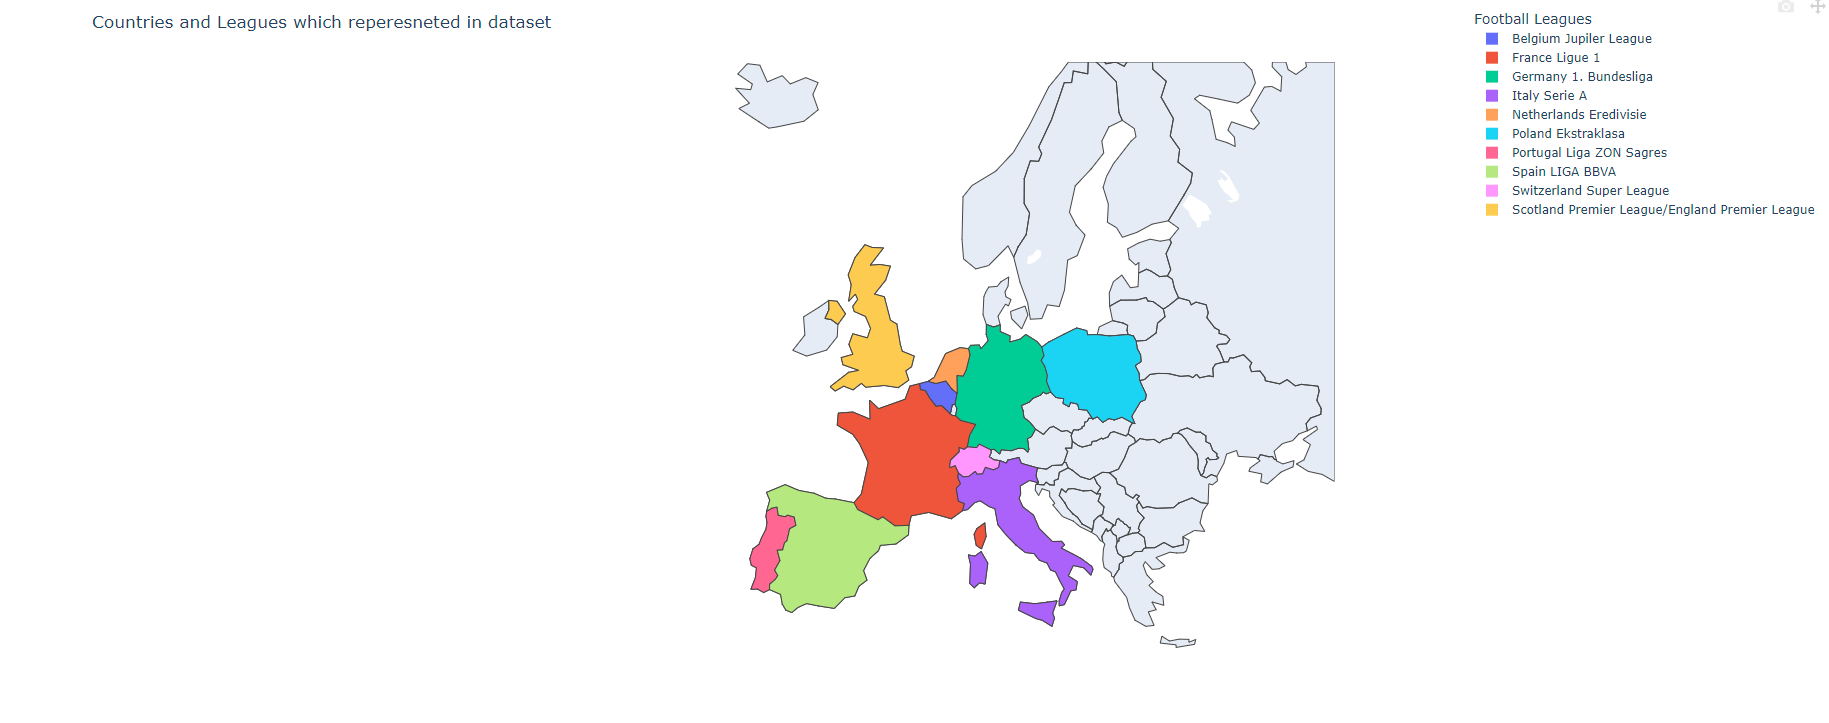

The map above perfectly displays all the countries and leagues represented. Only one country has two major leagues, that's the UK. However, the English Premier League is more prestigious than the Scottish Premier League.

### 2.2 The most scoring leagues

In this part, I took a look at the total number of goals of each represented league.

In [7]:
l_goals = pd.read_sql(
    """SELECT name, SUM(home_team_goal+away_team_goal) As all_goals
       FROM League
       Inner JOIN Match ON League.id = Match.league_id 
       GROUP BY name
       ORDER BY all_goals Desc   
""",
    conn,
)

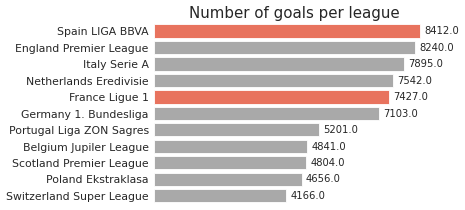

In [8]:
sns.set_style("white")
clrs = [
    "darkgray" if (x != 8412 and x != 7427) else "tomato" for x in l_goals.all_goals
]
ax = sns.barplot(x="all_goals", y="name", data=l_goals, palette=clrs)
sns.set(rc={"figure.figsize": (16, 12)})

for p in ax.patches:
    ax.annotate(
        "%.1f" % p.get_width(),
        xy=(p.get_width(), p.get_y() + p.get_height() / 2),
        xytext=(5, 0),
        textcoords="offset points",
        ha="left",
        va="center",
    )

plt.xticks([])
plt.ylabel("")
plt.xlabel("")
plt.title("Number of goals per league", fontsize=18)
plt.tick_params(labelsize=13)
sns.despine(bottom=True, left=True)

From the bar charts above, we can see that the leagues with the most goals are the Spanish BBVA League and the English Premier League. However, the German and French leagues are only in 5th and 6th places. Even though they have some great clubs. There may be several facts that could lead to such a difference:


*   Big difference in level between clubs in the league 
*   Different styles of football
*   The better players

To understand this difference, the leagues of Spain and France were chosen. But before proceeding to a deeper analysis, we need to check if there is a difference in the number of games played in both leagues.




In [9]:
n_games = pd.read_sql(
    """SELECT  name as League, COUNT(name) as Amount
FROM MATCH
Inner JOIN League ON Match.league_id = League.id
Where League = 'France Ligue 1' or League = 'Spain LIGA BBVA'
GROUP BY League  
""",
    conn,
)

n_games

,League,Amount
0,France Ligue 1,3040
1,Spain LIGA BBVA,3040


This dataset represents the same number of games in each league, so there is no need to normalize the data at the moment.


### 2.3 League difference

In this part, I focused on trying to find the key points that could lead to such a sharp goal difference in these two leagues.

#### 2.3.1 Overall rating difference

First, I checked how much the average player rating differs between Spanish and French clubs over all seasons.

In [10]:
Standing_in_league = pd.read_sql(
    """SELECT ALS.season, ALS.name, TM.team_long_name,  sum(ALS.team_score) as total
From  Team as TM
INNER JOIN AllScores as ALS On ALS.team_api_id = TM.team_api_id
GROUP BY ALS.team_api_id, ALS.season
Order By ALS.season, ALS.name, total DESC;
""",
    conn,
)

In [11]:
Players = pd.read_sql(
    """SELECT All_players.player_api_id, player_name, season, team_long_name, name, printf("%.f",  AVG(overall_rating)) AS Rating, printf("%.f",  AVG(potential)) as Potential
FROM All_players
INNER JOIN Player_Attributes ON All_players.player_api_id = Player_Attributes.player_api_id
GROUP BY player_name, season, team_long_name, name
Order By season, team_long_name
""",
    conn,
)

In [12]:
Players = convert_to_n(Players, "Rating")
Players = convert_to_n(Players, "Potential")

In [13]:
Players_rating = (
    Players.groupby(["season", "team_long_name", "name"])["Rating"].mean().round()
)
Players_rating = Players_rating.reset_index()
teams_players = merging(
    Players_rating, Standing_in_league, ["team_long_name", "name", "season"]
)
teams_players = teams_players.sort_values(
    by=["season", "name", "total"], ascending=[True, True, False]
)
teams_players.head()

,season,team_long_name,name,Rating,total
13,2008/2009,Girondins de Bordeaux,France Ligue 1,73.0,80
21,2008/2009,Olympique de Marseille,France Ligue 1,74.0,77
20,2008/2009,Olympique Lyonnais,France Ligue 1,77.0,71
15,2008/2009,LOSC Lille,France Ligue 1,73.0,64
22,2008/2009,Paris Saint-Germain,France Ligue 1,73.0,64


There are two most important columns in the table above:



1.   Average rating of players by club
2.   The total number of points scored by the team for each year

Unfortunately, the database did not provide us with information about which teams won their leagues. Thus, it was calculated using SQL queries (the code is shown in **Part 1.2** of this project). Calculations were carried out following these rules:


*   **3 points** - gets the team that won
*   **1 point** - get both teams if the match ended in a draw
*   **0 point** - gets the team that lost





<Figure size 960x720 with 0 Axes>

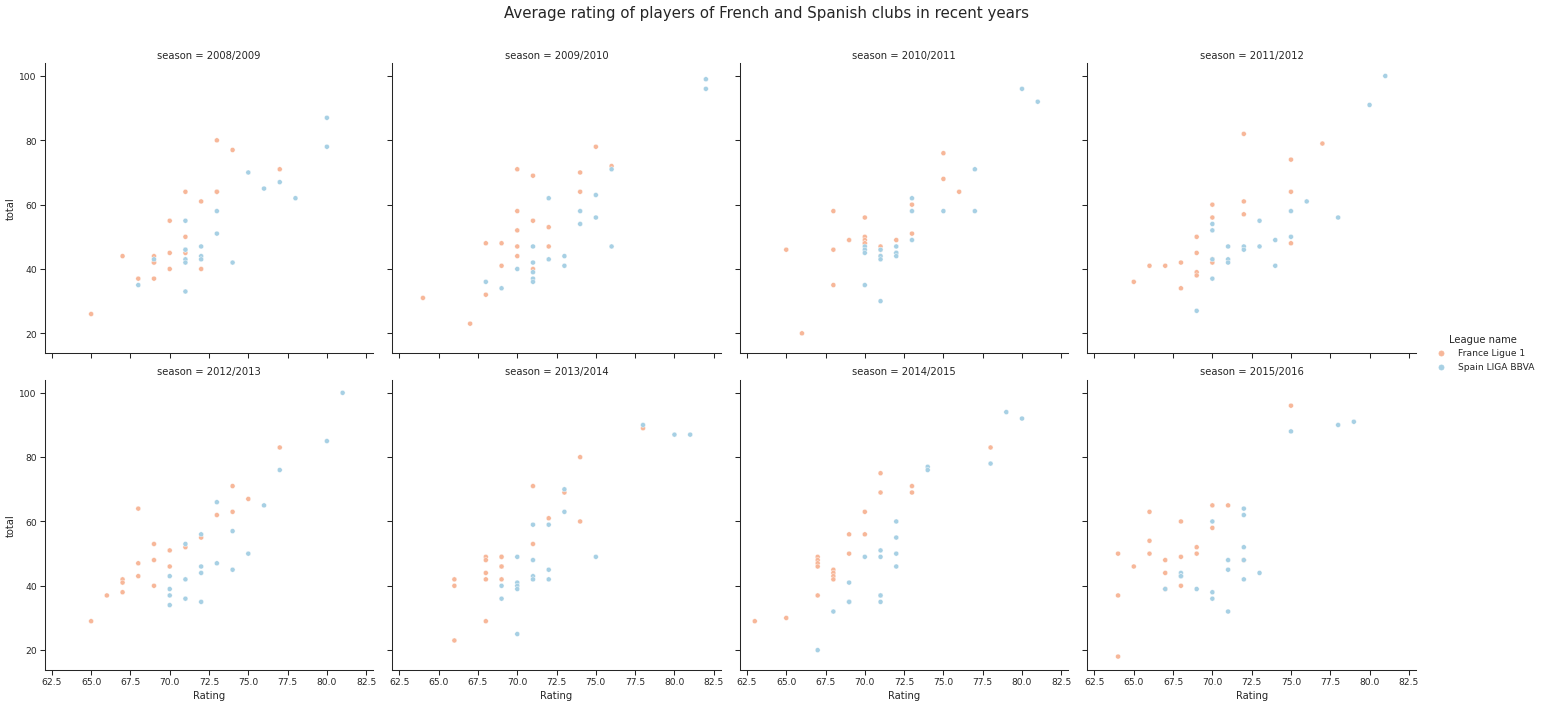

<Figure size 960x720 with 0 Axes>

In [14]:
sns.set_style("ticks")
sns.despine()
g = sns.relplot(
    data=teams_players,
    x="Rating",
    y="total",
    col="season",
    hue="name",
    palette="RdBu",
    kind="scatter",
    col_wrap=4,
    height=6,
    aspect=1,
)

g._legend.set_title("League name")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(
    "Average rating of players of French and Spanish clubs in recent years", fontsize=18
)
plt.show()
plt.savefig("newss.png")

This plot perfectly indicates that:


*   Teams with a higher average player rating scored more points during the season
*   The ratings of the players of the Spanish leagues are more scattered, and the French ones are distributed more tight

Based on this observation, it can be assumed that the French clubs are on the same level, while the Spanish ones are scattered. However, this trend began to change only in the 2013/2014 season, when the French had one dominant club.

Acordingly to [Wikipedia](https://en.wikipedia.org/wiki/Paris_Saint-Germain_F.C._ownership_and_finances) PSG (Paris Saint Germain) club was acuired  **Qatar Sports Investments**. This led to the creation of a new super club, in which there were many famous football players, and also influenced how the new dominant club appeared in the French league.


#### 2.3.2 Rating and Potential

The focus of this part is to check how the rating and potential of the players of the **"Liga BBVA"** and the **"French Ligue 1"** are distributed

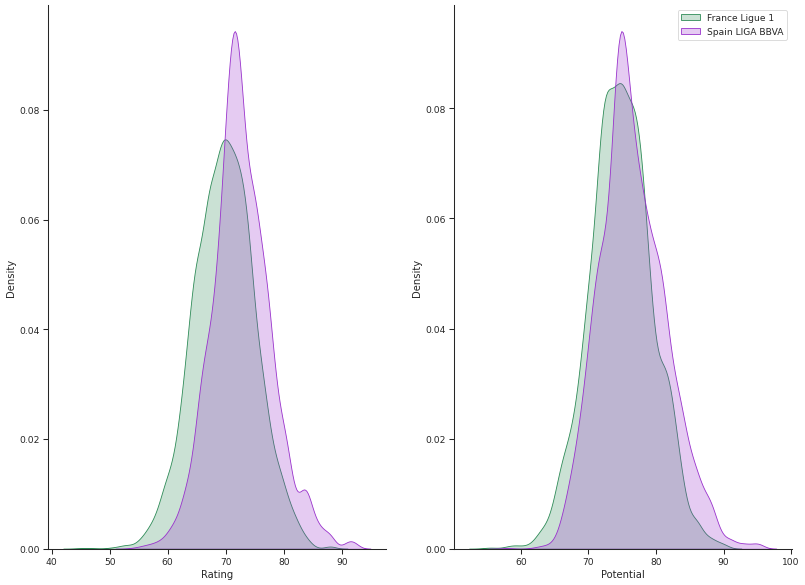

In [15]:
sns.set_style("ticks")
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.kdeplot(
    Players.loc[(Players["name"] == "France Ligue 1"), "Rating"],
    color="seagreen",
    shade=True,
    Label="France Ligue 1",
    ax=ax1,
)

sns.kdeplot(
    Players.loc[(Players["name"] == "Spain LIGA BBVA"), "Rating"],
    color="darkorchid",
    shade=True,
    Label="Spain LIGA BBVA",
    ax=ax1,
)

sns.kdeplot(
    Players.loc[(Players["name"] == "France Ligue 1"), "Potential"],
    color="seagreen",
    shade=True,
    Label="France Ligue 1",
    ax=ax2,
)

sns.kdeplot(
    Players.loc[(Players["name"] == "Spain LIGA BBVA"), "Potential"],
    color="darkorchid",
    shade=True,
    Label="Spain LIGA BBVA",
    ax=ax2,
)
sns.despine()
plt.legend()
plt.show()

The conclusions we have obtained from the above diagrams:
*   Both Rating and Potential are normally distributed
*   The average rating of Spanish league players is higher than that of the French
*   We can assume that the players of the Spanish league are giving their best since their potential and rating are almost the same
*   Last but not least, the players of the French league have room for improvement, and they have not yet reached their potential yet


#### 2.3.3 Difference between player ratings

I think it's important to check if the Spanish League players have a significantly higher average rating.

$H_0$ - there is no difference in the ratings between the Spanish and French  leagues.  
$H_a$ - Spanish League players have a higher average rating than the French.  
$\alpha = 0.05$  

In [16]:
rating = pd.DataFrame(
    Players.groupby(["name"]).agg(
        mean=("Rating", "mean"),
        std=("Rating", "std"),
        sample_size=("player_name", "count"),
    )
).reset_index()
rating

,name,mean,std,sample_size
0,France Ligue 1,69.705056,5.257272,3916
1,Spain LIGA BBVA,72.710223,5.156477,3903


In [17]:
# differencce of two means
ratings_mean = rating.iloc[1]["mean"] - rating.iloc[0]["mean"]
ratings_mean

3.0051667256820593

In [18]:
# estimated standard deviation
ratings_est_std = np.sqrt((rating.iloc[0]["std"] ** 2 + rating.iloc[1]["std"] ** 2) / 2)
ratings_est_std

5.207118399568464

In [19]:
# effect size
ratings_mean / ratings_est_std

0.57712663609322

To prevent p-hacking, a preliminary power analysis was carried out. After filling the calculator with the received values, the output of total sample size was equal to 100.

Sample size calculator: [ai-therapy](https://www.ai-therapy.com/psychology-statistics/sample-size-calculator)

In [20]:
spain_ra = Players[(Players["name"] == "Spain LIGA BBVA")]["Rating"]
france_ra = Players[(Players["name"] == "France Ligue 1")]["Rating"]

cm = sms.CompareMeans(sms.DescrStatsW(spain_ra), sms.DescrStatsW(france_ra))
lb, ub = cm.tconfint_diff(usevar="unequal")

print("Confidence Interval with 'sms' is from %0.4f to %0.4f" % (lb, ub))

Confidence Interval with 'sms' is from 2.7743 to 3.2360


The zero value does not fall within the boundaries of the confidence interval, which means that there is a significant difference between the average ratings of the players of the two leagues.

In [21]:
stat, p = ttest_ind(spain_ra, france_ra)

print("Using t-test from Python module:\nt_stat: %0.3f, \np_value: %0.3f" % (stat, p))

Using t-test from Python module:
t_stat: 25.516, 
p_value: 0.000


The P value is less than 0.05, so we can to reject a null hypothesis, and this means that there is a significant difference.

#### 2.3.4 Top scorers

In this part, I checked who is the top scorer of the French and Spanish leagues every season

In [22]:
players_scorers = pd.read_sql(
    """SELECT season, goal
FROM Match
INNER JOIN League ON Match.league_id = League.id 
WHERE goal IS NOT NULL and away_team_goal != 0 and home_team_goal != 0 and league_id = 4769	or league_id = 21518
""",
    conn,
)

In [23]:
scorers_lst = {"season": [], "Team_id": [], "player_api_id": []}
for rows, season in zip(players_scorers["goal"], players_scorers["season"]):
    if not rows:
        continue
    root = ET.fromstring(rows)
    for child in root:
        player = child.find("player1")
        team = child.find("team")
        if player != None and team != None:
            scorers_lst["season"].append(f"{season}")
            scorers_lst["Team_id"].append(f"{team.text}")
            scorers_lst["player_api_id"].append(f"{player.text}")

In [24]:
scorer = pd.DataFrame(scorers_lst)
scorers = g_count(
    scorer, ["season", "Team_id", "player_api_id"], "player_api_id", "Goals"
)
scorers = convert_to_n(scorers, "player_api_id")

In [25]:
players_scored = merging(Players, scorers, ["season", "player_api_id"])
players_scored_t = merging(
    Standing_in_league, players_scored, ["season", "team_long_name", "name"]
)
players_scored_t = players_scored_t.drop(
    columns=["player_api_id", "Team_id", "Potential"]
)

In [26]:
l_n_goals = players_scored_t.groupby(["season", "name"])["Goals"].max().reset_index()
l_n_goals = merging(l_n_goals, players_scored_t, ["season", "Goals", "name"])

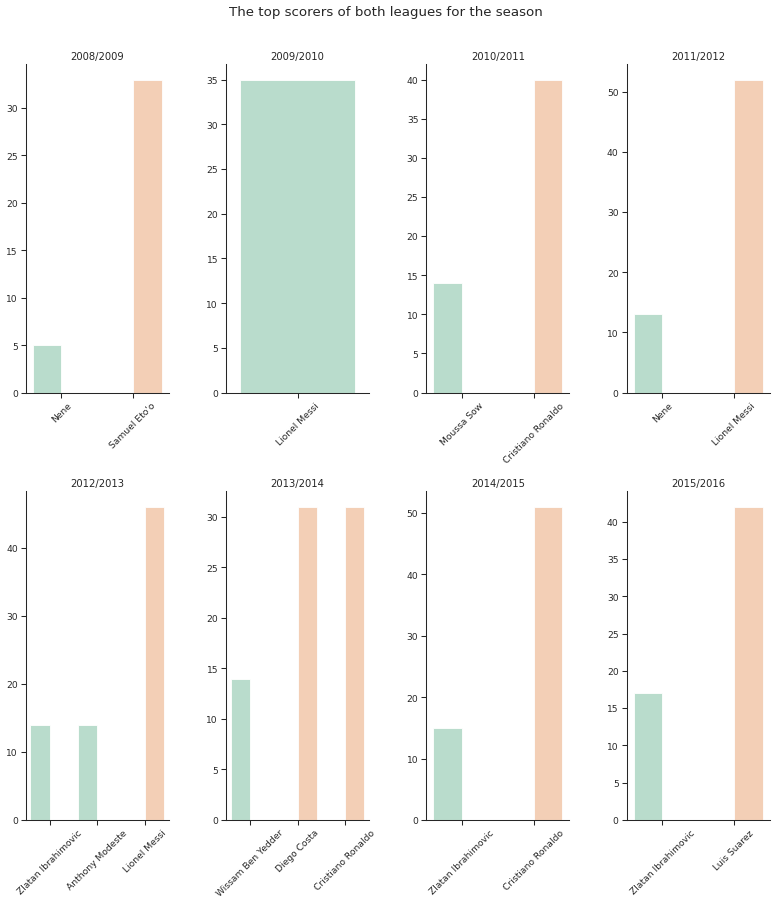

In [27]:
season_list = sorted(l_n_goals["season"].unique())
subplots(
    season_list,
    l_n_goals,
    "player_name",
    "Goals",
    "name",
    "season",
    "The top scorers of both leagues for the season",
    "League names",
)

The displayed graph shows green bars representing "Ligue de France 1" and orange "LIGUE de Spain BBVA", **except for 2009/2010**. We don't have any data on the top scorers of the French league this particular season.

Insights:
*   There is a huge difference in the number of goals between the top scorers in the two leagues. This may indicate that the assumption about the difference of clubs in the same league is correct. It may also be that there is a significant difference in the skills of the players.
*   In the 2012/2013 season, we have two players who scored the same number of goals, however, if Zlatan Ibrahimovic represented PSG (the winner of the French Ligue 1), then Anthony Modest was part of the club that took only 11th place. I believe this was an example of **regression to the mean**. He had one great season, which could be influenced by luck or other positive circumstances, and after that, the number of goals dropped to average, a and he never showed the same result.

**NOTE**: In the dataset for the French 2008/2009 season, only one value was specified. Also were missing 150 values for the 2010/2011  and 100 values for the 2011/2012 seasons. Therefore, we cannot unequivocally say that there was such a sharp difference in the number of goals in these seasons.

#### 2.3.5 Number of goals and overall rating

After such a difference in the number of goals between the top scorers has been noted, it is important to check the difference in the ratings of the best players.

In [28]:
top_rat = l_n_goals.drop_duplicates("player_name", keep="last")

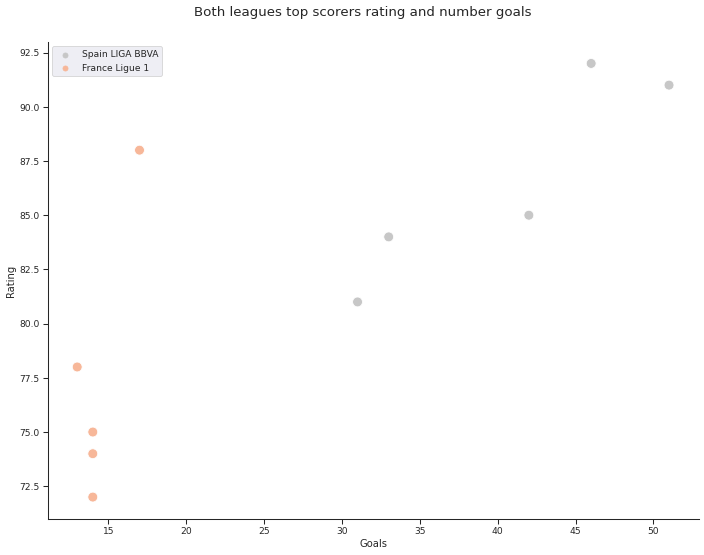

In [30]:
scater_1(
    top_rat,
    "Goals",
    "Rating",
    "name",
    "",
    "Both leagues top scorers rating and number goals",
    140,
)

Conclusion from the chart:
*   The rating of the French league players and goals are distributed more rigidly
*   The overall rating of the top scorers in the Spanish league is higher than the French one, but one player had a pretty big rating 
*   Even though the player of the French league had an overall rating of 88, at the same time he had half as many goals as the players of the Spanish league

We can assume that the clubs of the French league are more at the same level


#### 2.3.6 Defense and attack

In this part, I have analyzed the different levels of work in defense and offense of the 'Spanish BBVA LEAGUE' and the 'French Ligue 1'. [Fifaplay](https://www.fifplay.com/encyclopedia/work-rate) , these rates describe how players participate in attacks and defense.

In [ ]:
Players_style = pd.read_sql(
    """SELECT All_players.player_api_id, player_name, season, team_long_name, name, printf("%.f",  AVG(overall_rating)) AS Rating, printf("%.f",  AVG(potential)) as Potential, attacking_work_rate,  defensive_work_rate, preferred_foot
FROM All_players
INNER JOIN Player_Attributes ON All_players.player_api_id = Player_Attributes.player_api_id
WHERE  defensive_work_rate IS NOT NULL and attacking_work_rate IS NOT NULL and preferred_foot IS NOT NULL
GROUP BY player_name, season, team_long_name, name
Order By season, team_long_name
""",
    conn,
)

In [ ]:
values_a = list(
    set(sorted(Players_style.attacking_work_rate.unique()))
    - set(["high", "low", "medium"])
)

In [ ]:
Players_style = value_r(Players_style, "attacking_work_rate", "norm", "medium")
Players_style = value_r(Players_style, "defensive_work_rate", "ormal", "medium")
Players_style_a = to_drop_v(Players_style, "attacking_work_rate", values_a)

In [ ]:
values_d = list(
    set(sorted(Players_style.defensive_work_rate.unique()))
    - set(["high", "low", "medium"])
)
lists_d = ["ean", "tocky", "o", "es"]
for l in lists_d:
    values_d.remove(l)
values_d = [int(i) for i in values_d]

In [ ]:
for values in values_d:
    if values <= 4:
        Players_style_d = value_r(
            Players_style, "defensive_work_rate", f"{values}", "low"
        )
    elif values <= 6:
        Players_style_d = value_r(
            Players_style, "defensive_work_rate", f"{values}", "medium"
        )
    else:
        Players_style_d = value_r(
            Players_style, "defensive_work_rate", f"{values}", "high"
        )

Players_style_d = to_drop_v(Players_style_d, "defensive_work_rate", lists_d)

In [ ]:
defence = g_count(
    Players_style_d,
    ["name", "defensive_work_rate"],
    "defensive_work_rate",
    "Total amount",
)
attack = g_count(
    Players_style_a,
    ["name", "attacking_work_rate"],
    "attacking_work_rate",
    "Total amount",
)

In the columns defensive and attacking work, there were many incomprehensible values, which were droped, but at the same time, there were values from 0-10. These values were divided into the following groups:

*   **0-4** - low rate
*   **5-6** - medium rate
*   **7-10** - high rate

The same classification is used by Fifa.



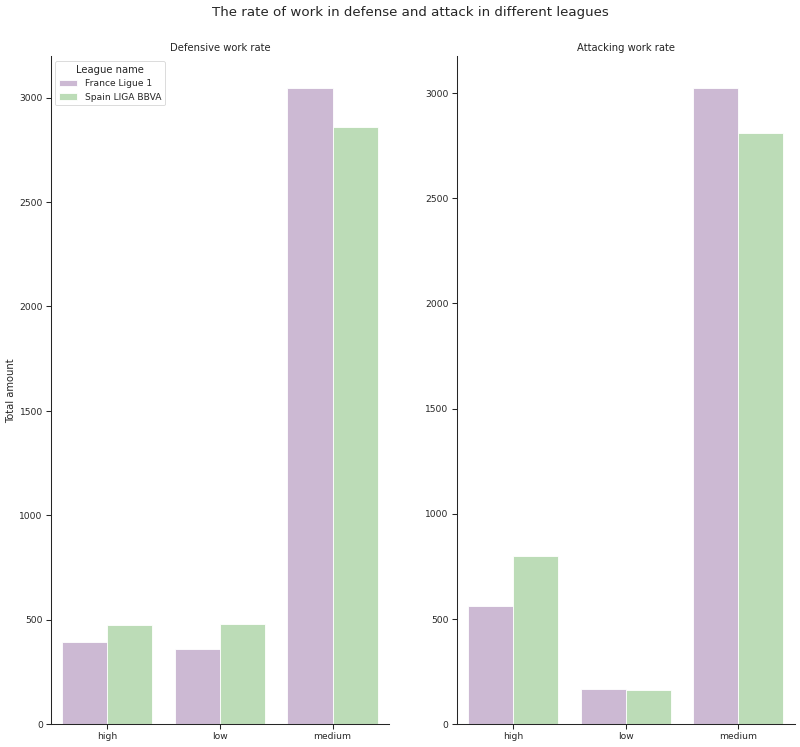

In [ ]:
sns.set_style("ticks")
fig, ax = plt.subplots(1, 2, figsize=(16, 14))
fig.suptitle("The rate of work in defense and attack in different leagues", fontsize=16)
axe1 = sns.barplot(
    data=defence,
    x="defensive_work_rate",
    y="Total amount",
    hue="name",
    ax=ax[0],
    palette="PRGn",
)
axe1.set(xlabel=None)
axe1.set(title="Defensive work rate")

axe2 = sns.barplot(
    data=attack,
    x="attacking_work_rate",
    y="Total amount",
    hue="name",
    ax=ax[1],
    palette="PRGn",
)
axe2.set(xlabel=None)
axe2.set(ylabel=None)
axe2.set(title="Attacking work rate")
axe2.legend([], [], frameon=False)

plt.subplots_adjust(top=0.92)
axe1.legend(title="League name")
sns.despine()
plt.show()

Insights:

*   Players tend to be more balanced between low and high speed, both offensively and defensively. However, this feature is a little more common for the French league
*   More Spanish players are attacking at a higher rate

It can be assumed that in the French league football is more balanced between attack and defense, and the players of the Spanish league tend to play more at higher rates.



#### 2.3.7 Yellow and red cards

Another feature of football is the cards that are issued to players due to violations of the rules. It can also determine the style of football, whether it is more aggressive or may indicate the behavior of players.

In [ ]:
cards = pd.read_sql(
    """SELECT season, card, name
FROM MATCH
INNER JOIN League ON Match.league_id = League.id 
WHERE card IS NOT NULL and league_id = 4769	or league_id = 21518
""",
    conn,
)

In [ ]:
cards_lst = {"season": [], "name": [], "player_api_id": []}
for rows, season, names in zip(cards["card"], cards["season"], cards["name"]):
    if not rows:
        continue
    root = ET.fromstring(rows)
    for child in root:
        player = child.find("player1")
        team = child.find("team")
        if player != None and team != None:
            cards_lst["season"].append(f"{season}")
            cards_lst["name"].append(f"{names}")
            cards_lst["player_api_id"].append(f"{player.text}")

In [ ]:
cards = pd.DataFrame(cards_lst)
cards = g_count(cards, ["season", "name"], "name", "Cards")
cards = to_drop_v(cards, "season", ["2008/2009", "2009/2010"])

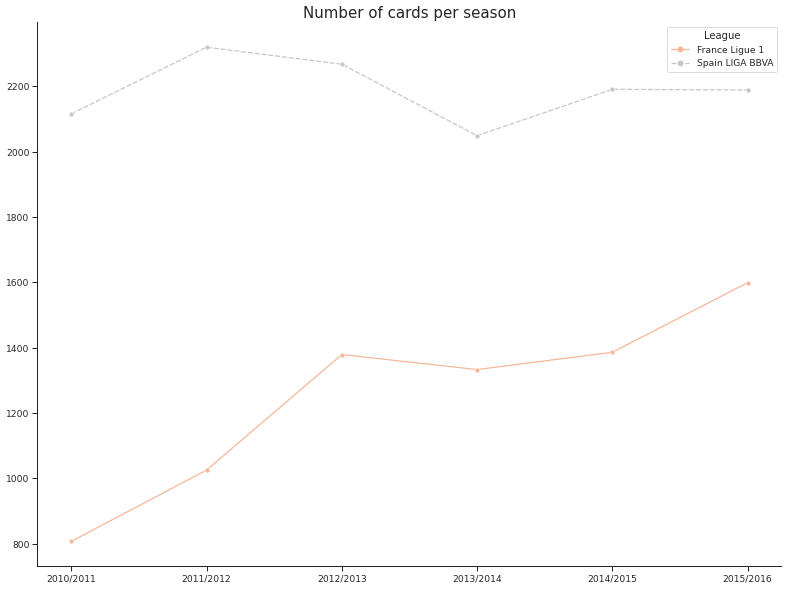

In [ ]:
sns.set_style("ticks")
plt.title("Number of cards per season", fontsize=18)
sns.lineplot(
    data=cards,
    x="season",
    y="Cards",
    hue="name",
    style="name",
    markers=["o", "o"],
    palette="RdGy",
)
sns.despine()
plt.legend(title="League")
plt.ylabel("")
plt.xlabel("")
plt.show()



*   Firstly, there is a huge difference in the number of cards received between the leagues, despite the missing values in the French seasons of 2010/2011 and 2011/2012
*   It can indicate that the Spanish football style is more aggressive and include more tackling
*   Of course, the Spanish league is known for such players as Pepe and Sergio Ramos. According to [Sportskeeda](https://www.sportskeeda.com/football/5-players-red-cards-la-liga-history/2), Sergio Ramos is a record holder for red cards in La Liga and he is in second place in the world rating



#### 2.3.8 Away games vs home games

The main focus in this section was on checking whether there is home advantage, and if so, is there a difference between the two leagues

In [ ]:
side_won = pd.read_sql(
    """SELECT MA.season, NAME,
CASE 
    WHEN home_team_goal > away_team_goal THEN 'home team won'
    WHEN home_team_goal < away_team_goal THEN 'away team won'
    END AS side_won
FROM MATCH As Ma
INNER JOIN League AS LG ON MA.league_id = LG.id
Where LG.name = 'France Ligue 1' or LG.name= 'Spain LIGA BBVA' 
ORDER BY name,  season
""",
    conn,
)

In [ ]:
side_won = side_won.dropna()

Several Null values indicated matches with a draw, but since the focus was on winning/losing, these values were droped.

In [ ]:
side_won = g_count(side_won, ["name", "side_won"], "side_won", "number_wins")

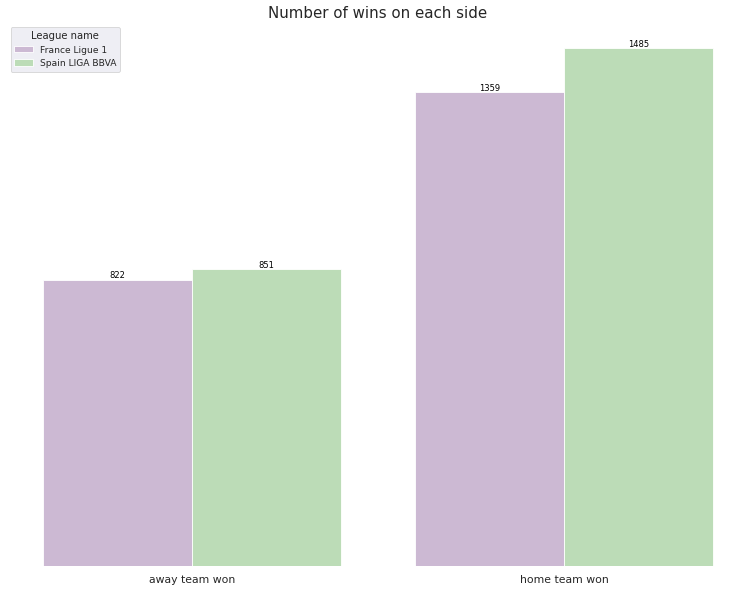

In [ ]:
sns.set_style("white")
ax = sns.barplot(
    data=side_won, x="side_won", y="number_wins", hue="name", palette="PRGn"
)

bar_annot(ax)
sns.set(rc={"figure.figsize": (16, 12)})
plt.yticks([])
plt.ylabel("")
plt.xlabel("")
plt.title("Number of wins on each side", fontsize=18)
plt.legend(title="League name")
plt.tick_params(labelsize=13)
sns.despine(bottom=True, left=True)

Information obtained from the bar plot:

*   In both leagues, there is a strong home advantage, slightly less than 2 times more victories were won on the home side
*   Since there were more matches in the Spanish League, it is unclear if there is any difference between the countries





In [ ]:
ratio_df = pd.DataFrame(
    data={
        "League name": [side_won.iloc[0, 0], side_won.iloc[2, 0]],
        "Win ratio": [
            side_won.iloc[1, 2] / side_won.iloc[0, 2],
            side_won.iloc[3, 2] / side_won.iloc[2, 2],
        ],
        "Win probability": [
            1 / ((side_won.iloc[1, 2] + side_won.iloc[0, 2]) / side_won.iloc[1, 2]),
            1 / ((side_won.iloc[3, 2] + side_won.iloc[2, 2]) / side_won.iloc[3, 2]),
        ],
    }
)
ratio_df

,League name,Win ratio,Win probability
0,France Ligue 1,1.653285,0.623109
1,Spain LIGA BBVA,1.745006,0.635702


This table indicates:

*   The Spanish home team has a slightly better chance of winning, and the ratio of home and away wins is greater than that of the French


### 2.4 Players difference

I will continue to look for the most important difference between the two leagues, but now I will focus more on the personal qualities, skills, and abilities of the players.

#### 2.4.1 Preferred foot

The purpose of this section is to find out if there are any significant differences between the two league players and which leg is the main one for them

In [ ]:
pref_foot = g_count(
    Players_style, ["name", "preferred_foot"], "preferred_foot", "total"
)
pref_foot = pd.DataFrame(
    data={
        "League name": [pref_foot.iloc[0, 0], pref_foot.iloc[2, 0]],
        "Foot ratio": [
            pref_foot.iloc[1, 2] / pref_foot.iloc[0, 2],
            pref_foot.iloc[3, 2] / pref_foot.iloc[2, 2],
        ],
    }
)
pref_foot

,League name,Foot ratio
0,France Ligue 1,3.668287
1,Spain LIGA BBVA,2.964103




*   Most of the football players are right-footed
*   However there is quite big difference between 'France Ligue 1' and 'Spain LIGA BBVA'



##### 2.4.1.1 Foot difference in France


Let's check if there is a significant difference in the number of goals between left-footed and right-footed players. First of all, I will study the French league.

H0  - there is no difference in the number of goals between the left and right footed players of the French league.

Ha  - right footed players have scored more goals than the left footed.

α=0.05

In [ ]:
foot_g = merging(
    Players_style, players_scored_t, ["name", "player_name", "team_long_name", "season"]
)
foot_g = foot_g.drop(
    columns=[
        "Rating_x",
        "attacking_work_rate",
        "defensive_work_rate",
        "Potential",
        "player_api_id",
        "total",
    ]
)
foot_f_g = foot_g[foot_g["name"].str.contains("France Ligue 1")]
foot_s_g = foot_g[foot_g["name"].str.contains("Spain LIGA BBVA")]

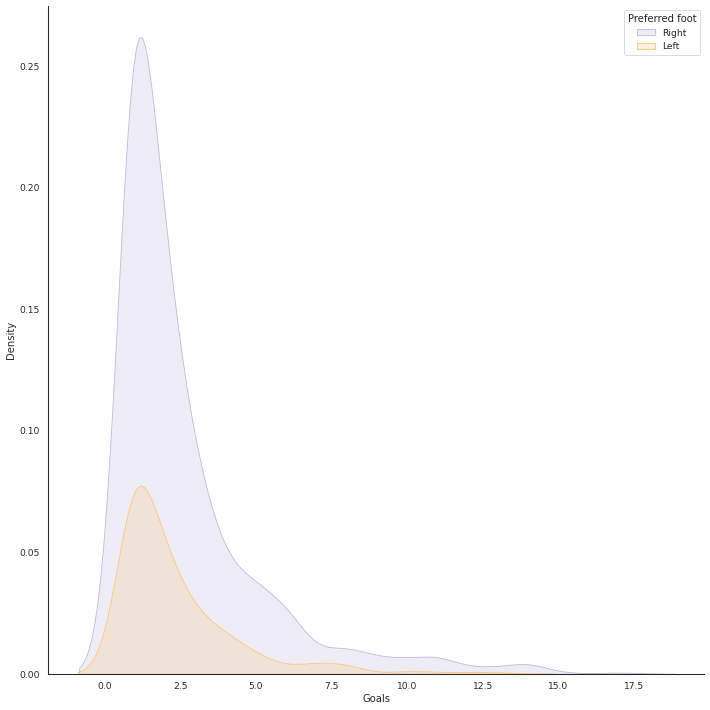

In [ ]:
sns.set_style("white")

g = sns.displot(
    foot_f_g,
    x="Goals",
    hue="preferred_foot",
    kind="kde",
    height=12,
    fill=True,
    legend=False,
    palette="PuOr",
)
plt.legend(title="Preferred foot", loc="upper right", labels=["Right", "Left"])
plt.show(g)

In [ ]:
foot_fra = pd.DataFrame(
    foot_f_g.groupby(["preferred_foot"]).agg(
        mean=("Goals", "mean"),
        std=("Goals", "std"),
        sample_size=("preferred_foot", "count"),
    )
).reset_index()
foot_fra

,preferred_foot,mean,std,sample_size
0,left,2.347267,1.993939,311
1,right,2.636784,2.487388,1082


We see that the average number of goals is very similar, however, the sample size is small, so we have to do a power analysis

In [ ]:
# differencce of two means
foot_fra_mean = foot_fra.iloc[1]["mean"] - foot_fra.iloc[0]["mean"]
foot_fra_mean

0.28951685279730865

In [ ]:
# estimated standard deviation
foot_fra__est_std = np.sqrt(
    (foot_fra.iloc[0]["std"] ** 2 + foot_fra.iloc[1]["std"] ** 2) / 2
)
foot_fra__est_std

2.2542062608003537

In [ ]:
# effect size
foot_fra_mean / foot_fra__est_std

0.12843405585011372

To prevent p-hacking, a preliminary power analysis was carried out. After filling the calculator with the received values, the output of total sample size was equal to 1905. Well there is a chance of p-hacking as our total sample size is 1393.

Sample size calculator: [ai-therapy](https://www.ai-therapy.com/psychology-statistics/sample-size-calculator)

In [ ]:
left_fra = foot_f_g[(foot_f_g["preferred_foot"] == "left")]["Goals"]
right_ra = foot_f_g[(foot_f_g["preferred_foot"] == "right")]["Goals"]

cm = sms.CompareMeans(sms.DescrStatsW(right_ra), sms.DescrStatsW(left_fra))
lb, ub = cm.tconfint_diff(usevar="unequal")

print("Confidence Interval with 'sms' is from %0.4f to %0.4f" % (lb, ub))

Confidence Interval with 'sms' is from 0.0224 to 0.5566


In [ ]:
stat, p = ttest_ind(right_ra, left_fra)

print("Using t-test from Python module:\nt_stat: %0.3f, \np_value: %0.4f" % (stat, p))

Using t-test from Python module:
t_stat: 1.886, 
p_value: 0.0595


From the above result, it is not very clear whether there is a significant difference between the number of goals. We also have to take into account the fact that the p-value can be p-hacked. So if we take a confidence interval, we can argue that there is a difference in the number of goals between left-footed and right-footed players.

##### 2.4.1.2 Foot difference in Spain

Now let's do an alternative hypothesis test for the Spanish League

H0  - there is no difference in the number of goals between the left and right footed players of the Spanish league.

Ha  - right footed players have scored more goals than the left footed.

α=0.05

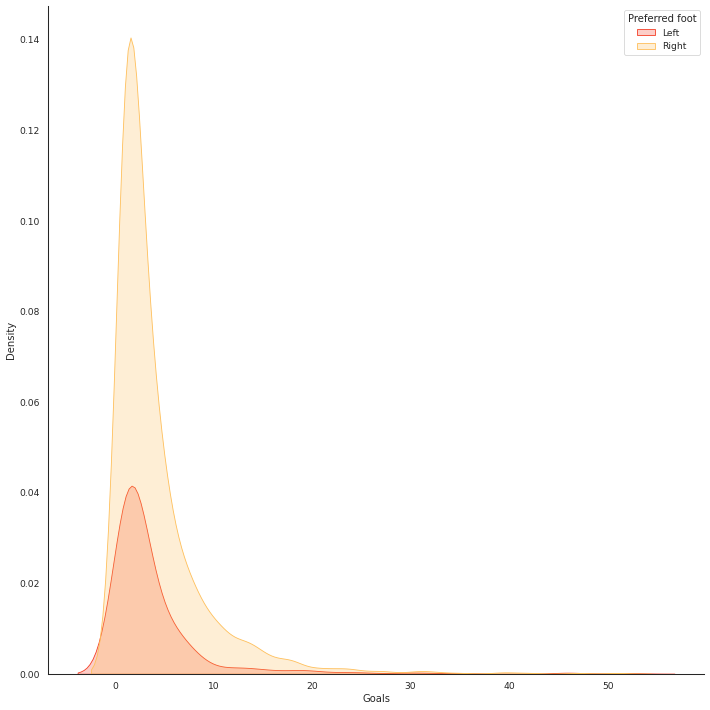

In [ ]:
sns.set_style("white")

g = sns.displot(
    foot_s_g,
    x="Goals",
    hue="preferred_foot",
    kind="kde",
    height=12,
    fill=True,
    legend=False,
    palette="YlOrRd",
)
plt.legend(title="Preferred foot", loc="upper right", labels=["Left", "Right"])
plt.show(g)

In [ ]:
foot_spai = pd.DataFrame(
    foot_s_g.groupby(["preferred_foot"]).agg(
        mean=("Goals", "mean"),
        std=("Goals", "std"),
        sample_size=("preferred_foot", "count"),
    )
).reset_index()
foot_spai

,preferred_foot,mean,std,sample_size
0,left,3.789374,5.582704,527
1,right,4.133706,4.977251,1608


From the above data, we can conclude that there is a somewhat large difference in the average number of goals compared to the French league. We may also face the problem of p-hacking because the number of samples is also very different.

In [ ]:
# differencce of two means
foot_spai_mean = foot_spai.iloc[1]["mean"] - foot_spai.iloc[0]["mean"]
foot_spai_mean

0.3443326536199458

In [ ]:
# estimated standard deviation
foot_spai_est_std = np.sqrt(
    (foot_spai.iloc[0]["std"] ** 2 + foot_spai.iloc[1]["std"] ** 2) / 2
)
foot_spai_est_std

5.2886484610190685

In [ ]:
# effect size
foot_spai_mean / foot_spai_est_std

0.06510787324170085

To prevent p-hacking, a preliminary power analysis was carried out. After filling the calculator with the received values, the output of total sample size was equal to 3750. Well there is a chance of p-hacking as our total sample size is 2135.

Sample size calculator: [ai-therapy](https://www.ai-therapy.com/psychology-statistics/sample-size-calculator)

In [ ]:
left_spai = foot_s_g[(foot_s_g["preferred_foot"] == "left")]["Goals"]
right_spai = foot_s_g[(foot_s_g["preferred_foot"] == "right")]["Goals"]

cm = sms.CompareMeans(sms.DescrStatsW(right_spai), sms.DescrStatsW(left_spai))
lb, ub = cm.tconfint_diff(usevar="unequal")

print("Confidence Interval with 'sms' is from %0.4f to %0.4f" % (lb, ub))

Confidence Interval with 'sms' is from -0.1916 to 0.8803


In [ ]:
stat, p = ttest_ind(right_spai, left_spai)

print("Using t-test from Python module:\nt_stat: %0.3f, \np_value: %0.4f" % (stat, p))

Using t-test from Python module:
t_stat: 1.336, 
p_value: 0.1816


We can conclude that, firstly, we cannot reject the null hypothesis, since the value of p is much greater than 0.05. Also, 0 falls within the boundaries of the confidence interval, so we can say that there was no significant difference.

##### 2.4.1 Conclusion


*   There is bigger number of right-footed players in French league
*   We can assume that there is a difference in the number of goals between a right-footed and a left-footed player of the French league
*   I didn't notice a significant difference in the number of goals in the Spanish League



#### 2.4.2 Correlation of player characteristics

The purpose of this section is to learn more about which characteristics affect the number of goals.

**NOTE**: The difference in the correlation between the two leagues is insufficient, so it will not be compared.

In [ ]:
Players_atts = pd.read_sql(
    """SELECT player_name, All_players.season, name, *
FROM All_players
INNER JOIN Player_Attributes ON All_players.player_api_id = Player_Attributes.player_api_id
GROUP BY player_name, All_players.season, team_long_name, name
Order By All_players.season, team_long_name
""",
    conn,
)

In [ ]:
Players_atts = Players_atts.loc[:, ~Players_atts.columns.duplicated()]
Players_atts = merging(Players_atts, scorers, ["season", "player_api_id"])
Players_atts = to_drop_v(
    Players_atts, "season", ["2008/2009", "2009/2010", "2010/2011", "2011/2012"]
)
Players_att = Players_atts.drop(
    columns=[
        "player_api_id",
        "Team_id",
        "id",
        "overall_rating",
        "potential",
        "player_fifa_api_id",
        "gk_diving",
        "gk_handling",
        "gk_kicking",
        "gk_positioning",
        "gk_reflexes",
    ]
)

In [ ]:
corr = (
    Players_att[Players_att.columns[1:]]
    .corr()["Goals"][:]
    .sort_values()
    .reset_index(name="Correlation")
)
corr.style.apply(
    lambda x: ["background: #DF2E2E" if x.name in [0, 4, 24, 27] else "" for i in x],
    axis=1,
)

,index,Correlation
0,marking,-0.338042
1,standing_tackle,-0.319771
2,interceptions,-0.318579
3,sliding_tackle,-0.318509
4,aggression,-0.089675
5,long_passing,-0.041811
6,strength,0.015640
7,balance,0.054138
8,jumping,0.088531
9,stamina,0.092402


Conclusions from the table and highlighted data:
*   Most positive impacts have finishing and most negative marking (organised defensive tactic), however, there is no feature that could have a strong correlation
*   Aggression is one of the features that negatively affects scoring goals, I think because it can be punished with a yellow or red card
*   Also, one unexpected thing is that penalties have a pretty low correlation, however, I thought this would be one of the most important features

It is important to know that the correlation consists of the attributes of the scored players



### 2.5 Teams difference 

Finally, I will study some key features of the teams to identify more differences between the two leagues, and perhaps we will observe features that can also affect such a difference in goals.

#### 2.5.1 Defense tactics

First, let's check which way of defense is more dominant in the selected leagues

In [ ]:
team_att = pd.read_sql(
    """SELECT Distinct Team_s.team_api_id as team_api_ids, Team_s.season as Seasons,Team_s.name as League_name, Team_Attributes.team_api_id, *
From (SELECT SUM(team_score), name, season, team_api_id From AllScores GROUP BY season, team_api_id, name) as Team_s
INNER JOIN Team_Attributes ON Team_s.team_api_id = Team_Attributes.team_api_id
""",
    conn,
)

In [ ]:
team_att = team_att.drop_duplicates(subset=["team_api_id", "name", "season"])
team_att = team_att.drop(
    columns=[
        "SUM(team_score)",
        "season",
        "team_api_ids",
        "name",
        "date",
        "id",
        "team_api_id",
    ]
)

In [ ]:
def_t = g_count(
    team_att,
    ["League_name", "defenceDefenderLineClass"],
    "defenceDefenderLineClass",
    "total",
)

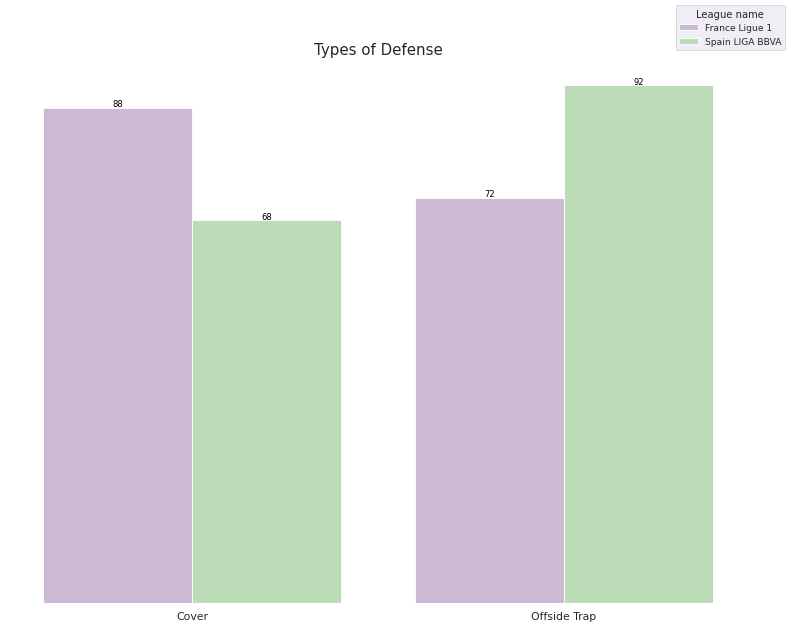

In [ ]:
sns.set_style("white")
ax = sns.barplot(
    data=def_t,
    x="defenceDefenderLineClass",
    y="total",
    hue="League_name",
    palette="PRGn",
)

bar_annot(ax)
sns.set(rc={"figure.figsize": (16, 12)})
plt.yticks([])
plt.ylabel("")
plt.xlabel("")
plt.title("Types of Defense", fontsize=18)
plt.legend(title="League name", bbox_to_anchor=(0.9, 1.1), loc=2, borderaxespad=0.0)
plt.tick_params(labelsize=13)
sns.despine(bottom=True, left=True)

*  There are different dominant defense strategies in both leagues
*  I believe that Spanish teams use riskier but at the same time more profitable ones. One of best examples: [Youtube](https://www.youtube.com/watch?v=Jndat8uP8LM&ab_channel=FOOTBALLISMESSILM10)
*  We can assume that a riskier strategy can lead to more goals since sometimes it doesn't pay off

#### 2.5.2 Tactics difference

One of most important things between two leagues is football style, and tactis perfectly defines it. In this section we will observe 3 main things which are relaited to tactics:

**Build up play** - it describes the team's attack. For example how fast attacks are put together

**Chance Creation** - explains how the team passing and how often it tries to shoot

**Defence** - describes how the team defends

In addition, several hypotheses will be tested to highlight the main difference.

Source: [Fifaplay](https://www.fifplay.com/fifa-18-tactics/)

##### 2.5.2.1 Build up play

It consists of:

*   Speed - The speed in which attacks are put together
      *  1-33: SLOW
      *  34-66: BALANCED
      *  66-100: FAST
*   Passing - Affects passing distance & support from teammates
      *  1-33: SHORT
      *  34-66: MIXED
      *  66-100: LONG


H0  - there is no difference in the same features between the French and the Spanish leagues.

Ha  - difference in the same features between the French and the Spanish leagues.

α=0.05


**NOTE:** Dribbling was not included, as we have no values for it, and I could not find any source with a proper description.


In [ ]:
build_up = team_att.drop(columns=["buildUpPlayDribbling"])
sp_team, fr_team = df_form(build_up, "buildUp|League_name")

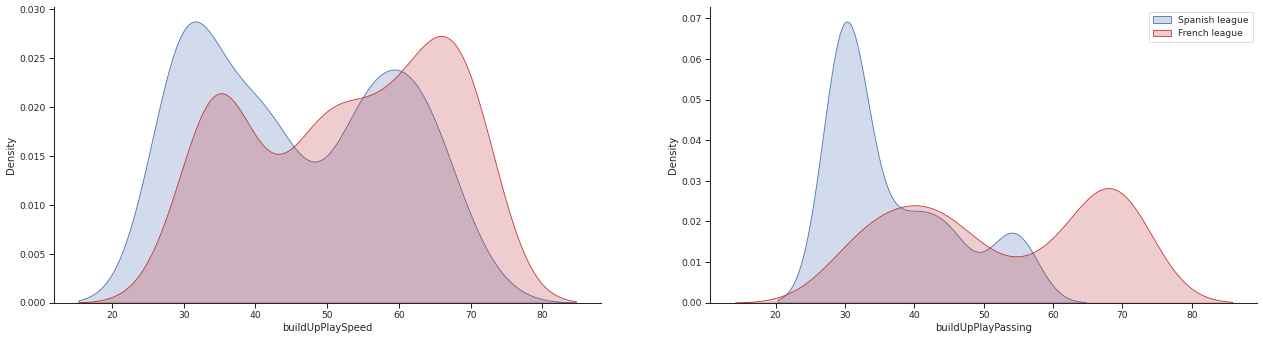

In [ ]:
hists_sub(sp_team, fr_team)

In [ ]:
feature_list = list(fr_team.columns)[:]
diff_mean = c_means(fr_team, sp_team, feature_list).round(3)
diff_mean["significance"] = diff_mean["p-value"].apply(eval_p)
diff_mean

,p-value,t-statistic,CI lower,CI upper,significance
feature,,,,,
buildUpPlaySpeed,0.0,4.551,3.892,9.821,Stat. significant difference
buildUpPlayPassing,0.0,11.489,12.859,18.179,Stat. significant difference



*   The data of both features are distributed very differently
*   Spanish attacks are slower than the French and include more short passing. It can indicate that French teams are more play counter-attack football, without high pressing
*   As expected, we see that there is a significant difference between these two leagues



##### 2.5.2.2 Chance Creation

It consists of:

*   Passing - Amount of risk in pass decision and run support
      *  1-33: SAFE
      *  34-66: NORMAL
      *  66-100: RISKY
*   Crossing - The tendency / frequency of crosses into the box
      *  1-33: LITTLE
      *  34-66: NORMAL
      *  66-100: LOTS
*   Shooting - The tendency / frequency of shots taken
      *  1-33: LITTLE
      *  34-66: NORMAL
      *  66-100: LOTS

H0  - there is no difference in the same features between the French and the Spanish leagues.

Ha  - difference in the same features between the French and the Spanish leagues.

α=0.05

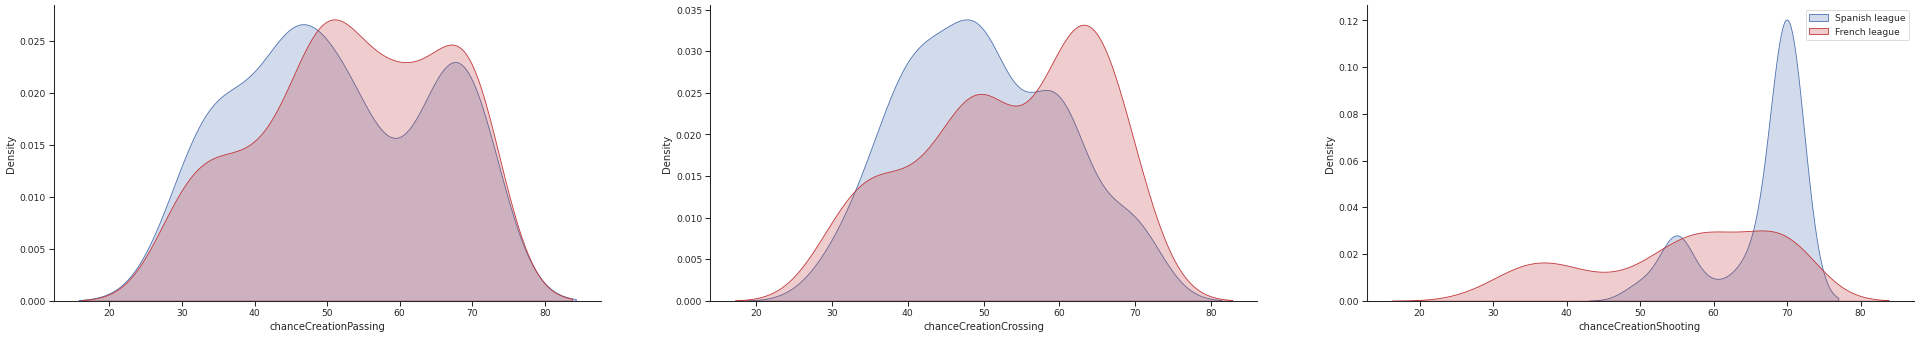

In [ ]:
sp_team, fr_team = df_form(build_up, "chance|League_name")
hists_sub(sp_team, fr_team)

In [ ]:
feature_list = list(fr_team.columns)[:]
diff_mean = c_means(fr_team, sp_team, feature_list).round(3)
diff_mean["significance"] = diff_mean["p-value"].apply(eval_p)

diff_mean

,p-value,t-statistic,CI lower,CI upper,significance
feature,,,,,
chanceCreationPassing,0.141,1.476,-0.707,4.957,Not enough evidence
chanceCreationCrossing,0.007,2.713,0.929,5.834,Stat. significant difference
chanceCreationShooting,0.000,-9.542,-12.969,-8.531,Stat. significant difference




*   All feature are very different, except Creation Passing
*   French teams shoot more balanced, at the same time Spanish are shooting as much as they can
*   As I mentioned in the previous part(2.5.2.1) probably French players are playing more counter-attack football as they tend to do more crossings
*   Finally, the French players give more risky passes



##### 2.5.2.3 Defence

It consists of:

*   Pressure - Affects how high up the pitch the team will start pressuring
      *  1-33: DEEP
      *  34-66: MEDIUM
      *  66-100: HIGH
*   Aggression - Affect the team’s approach to tackling the ball possessor
      *  1-33: CONTAIN
      *  34-66: PRESS
      *  66-100: DOUBLE
*   Team Width - Affects how much the team will shift to the ball side
      *  1-33: NARROW
      *  34-66: NORMAL
      *  66-100: WIDE

H0  - there is no difference in the same features between the French and the Spanish leagues.

Ha  - difference in the same features between the French and the Spanish leagues.

α=0.05

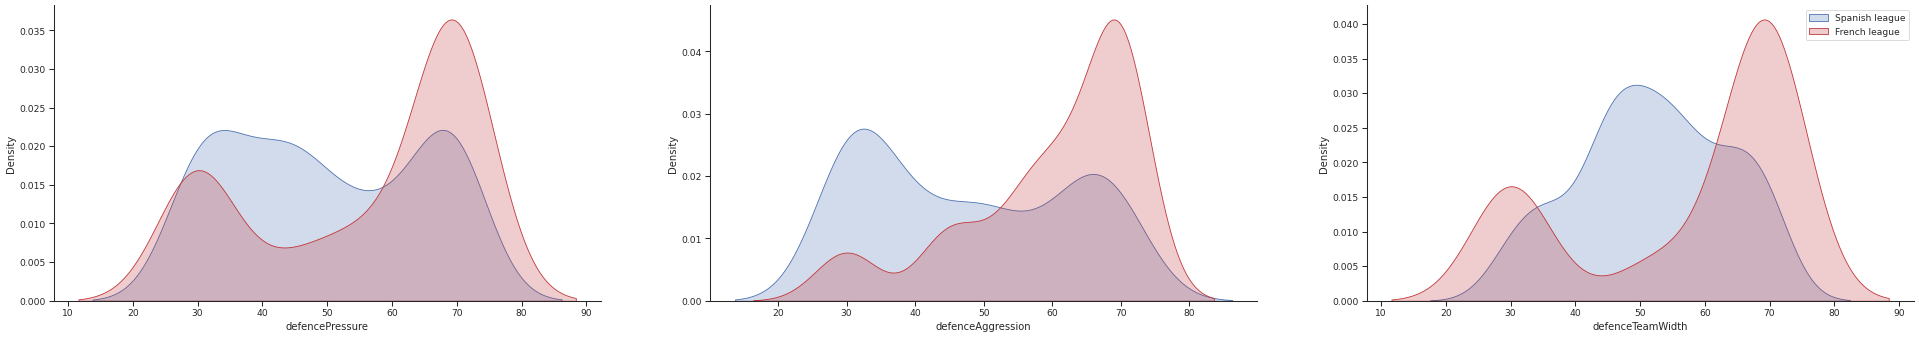

In [ ]:
sp_team, fr_team = df_form(build_up, "defence|League_name")
hists_sub(sp_team, fr_team)

In [ ]:
feature_list = list(sp_team.columns)[:]
diff_mean = c_means(fr_team, sp_team, feature_list).round(3)
diff_mean["significance"] = diff_mean["p-value"].apply(eval_p)
diff_mean

,p-value,t-statistic,CI lower,CI upper,significance
feature,,,,,
defencePressure,0.000,3.535,2.794,9.806,Stat. significant difference
defenceAggression,0.000,7.943,9.225,15.300,Stat. significant difference
defenceTeamWidth,0.001,3.519,2.506,8.869,Stat. significant difference




*   As before, all features are significantly different
*   Even though Spanish players receive red/yellow cards twice as much as French players, but French players defend more aggressively
*   Spanish Teams use normal width, while French to be more wide
*   Finally, the pressure of the Spanish players is more balanced throughout the field, while the French press high or deep on the field. And this also partially confirms my assumptions about the football style of French teams





## 3 Predictions

### 3.1 Wining team of French league

In this section, I will use logistic regression to predict the outcome of a match in French league. Where there are three possible outcomes: **Victory**, **Defeat**, **Draw**. The main features that were used:

*   Numeric attributes of the teams
*   Overall player ratings
*   Bookmaker's data
*   History of matches between teams




In [ ]:
player_stats = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
match_data = pd.read_sql("SELECT * FROM MATCH WHERE league_id = 4769;", conn)
team_stats = pd.read_sql(
    "SELECT team_api_id, buildUpPlaySpeed,  buildUpPlayPassing, chanceCreationPassing, chanceCreationCrossing, chanceCreationShooting, defencePressure, defenceAggression, defenceTeamWidth FROM Team_Attributes;",
    conn,
)

match_data.dropna(inplace=True)
match_data = match_data

In [ ]:
fifa_data = match_data.apply(lambda x: get_fifa_stats(x, player_stats), axis=1)

In [ ]:
up_fifa = pd.merge(
    fifa_data,
    team_stats,
    how="inner",
    left_on="home_teamapi_id",
    right_on="team_api_id",
)
col_names = ["build", "chance", "defence"]
for names in col_names:
    up_fifa.columns = [
        "home_" + col if f"{names}" in col else col for col in up_fifa.columns
    ]

In [ ]:
up_fifa = pd.merge(
    up_fifa, team_stats, how="inner", left_on="away_teamapi_id", right_on="team_api_id"
)

In [ ]:
pd.options.mode.chained_assignment = None
bk_cols_selected = ["B365", "BW"]
feables = create_feables(match_data, up_fifa, bk_cols_selected)
inputs = feables.drop("match_api_id", axis=1)
plt.rcParams["figure.dpi"] = 70

In [ ]:
Y = inputs["label"]
X = inputs.loc[:, inputs.columns != "label"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [ ]:
model_log = ImPipeline(
    [
        ("scaler", StandardScaler()),
        ("smote", SMOTE(k_neighbors=4, random_state=42)),
        ("log", LogisticRegression(solver="lbfgs", max_iter=1000)),
    ]
).fit(X_train, y_train);

In [ ]:
print(classification_report(y_test, model_log.predict(X_test)))

              precision    recall  f1-score   support

      Defeat       0.50      0.59      0.54       817
        Draw       0.45      0.48      0.46       844
         Win       0.66      0.55      0.60      1306

    accuracy                           0.54      2967
   macro avg       0.54      0.54      0.53      2967
weighted avg       0.56      0.54      0.55      2967



In this particular case, I believe that the best indicator that can be trusted is the F1 score, since we want to be sure that the predicted result is true, and we want to predict as many such results as possible.

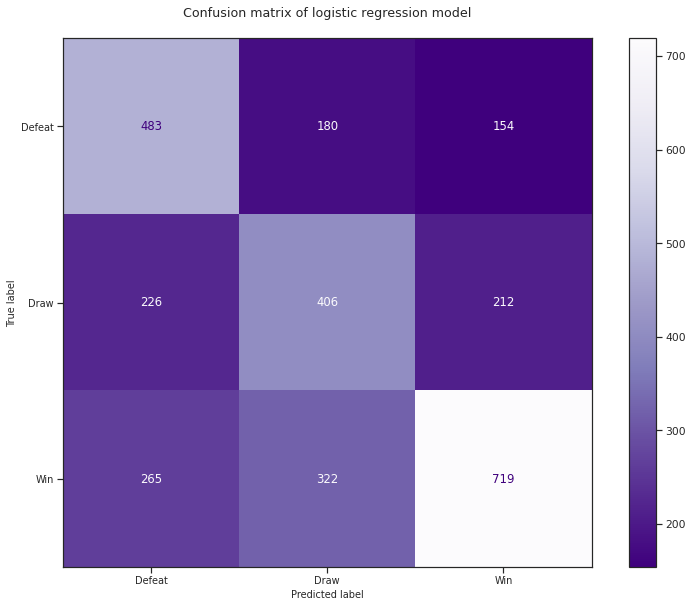

In [ ]:
plot_cm(
    model_log,
    X_test,
    y_test,
    display_labels=["Defeat", "Draw", "Win"],
    cmap="Purples_r",
    title="Confusion matrix of logistic regression model",
)

From the confusion matrix, we can conclude that there are fewer false - negative values than true ones. Also, the most accurate predictions are given for winnings.

### 3.2 Number of goals in French league

In this part, I will try to predict how many goals could be scored during the match. Main features which were used: 


*   Numeric attributes of the teams
*   Overall player ratings
*   Number of red and yellow cards
*   Number of gaols



In [ ]:
cards = pd.read_sql(
    """SELECT season, card, name, match_api_id, home_team_api_id, away_team_api_id
FROM MATCH
INNER JOIN League ON Match.league_id = League.id 
WHERE card IS NOT NULL and league_id = 4769 
""",
    conn,
)

In [ ]:
home_r = card_t(cards, "home_r", "r", cards["home_team_api_id"])
home_y = card_t(cards, "home_y", "y", cards["home_team_api_id"])
away_r = card_t(cards, "away_r", "r", cards["away_team_api_id"])
away_y = card_t(cards, "away_y", "y", cards["away_team_api_id"])

In [ ]:
home_r = g_count(home_r, ["match_api_id"], "home_r", "home_r")
home_y = g_count(home_y, ["match_api_id"], "home_y", "home_y")
away_r = g_count(away_r, ["match_api_id"], "away_r", "away_r")
away_y = g_count(away_y, ["match_api_id"], "away_y", "away_y")

In [ ]:
home_cards = pd.merge(home_r, home_y, on="match_api_id", how="outer")
away_cards = pd.merge(away_r, away_y, on="match_api_id", how="outer")
both_cards = pd.merge(home_cards, away_cards, on="match_api_id", how="outer")
both_cards = convert_to_n(both_cards, "match_api_id")
both_cards = both_cards.fillna(0)

In [ ]:
goals_t = pd.read_sql(
    """SELECT match_api_id, home_team_goal, away_team_goal
FROM MATCH
WHERE league_id = 4769	
""",
    conn,
)

In [ ]:
feables_u = pd.merge(feables, both_cards, on="match_api_id", how="outer")

In [ ]:
feables_u = pd.merge(feables_u, goals_t, on="match_api_id", how="outer")

In [ ]:
feables_u.dropna(inplace=True)

In [ ]:
feables_u = feables_u.drop(
    columns=[
        "home_team_goals_difference",
        "away_team_goals_difference",
        "games_won_home_team",
        "games_won_away_team",
        "games_against_won",
        "games_against_lost",
        "League_4769.0",
        "label",
    ]
)

In [ ]:
feables_u = feables_u[~(feables_u["home_team_goal"] >= 5)]
feables_u = feables_u[~(feables_u["away_team_goal"] >= 5)]

The number of goals that were 5 or higher was usually outliers, so they were removed

In [ ]:
Y = feables_u["home_team_goal"]
X = feables_u.loc[:, feables_u.columns != "home_team_goal"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [ ]:
model_log = ImPipeline(
    [
        ("scaler", StandardScaler()),
        ("smote", SMOTE(k_neighbors=4, random_state=42)),
        ("log", LogisticRegression(solver="lbfgs", max_iter=1000)),
    ]
).fit(X_train, y_train);

In [ ]:
print(classification_report(y_test, model_log.predict(X_test)))

              precision    recall  f1-score   support

           0       0.47      0.49      0.48       693
           1       0.55      0.37      0.45       966
           2       0.46      0.36      0.40       659
           3       0.35      0.51      0.42       342
           4       0.26      0.63      0.37       188

    accuracy                           0.43      2848
   macro avg       0.42      0.47      0.42      2848
weighted avg       0.47      0.43      0.44      2848



As in the previous part, I believe that the most reliable indicator is the f1 score. We see that almost all f1 results are the same, except for 4 goals.

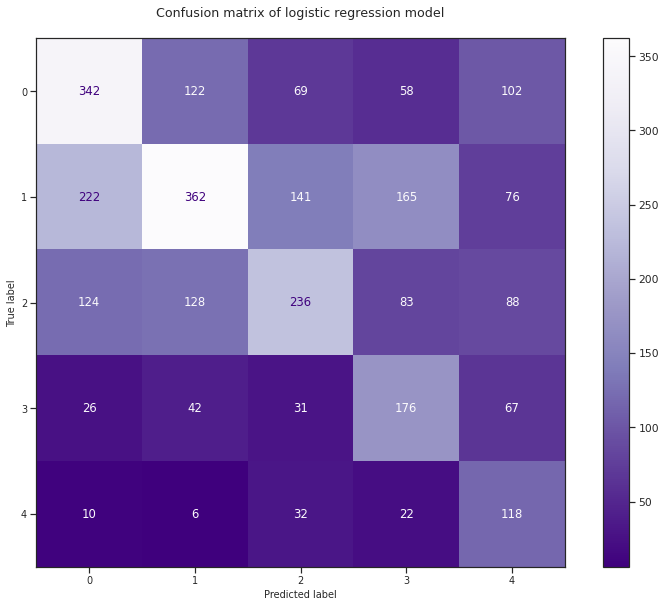

In [ ]:
plot_cm(
    model_log,
    X_test,
    y_test,
    display_labels=[0, 1, 2, 3, 4],
    cmap="Purples_r",
    title="Confusion matrix of logistic regression model",
)

There are not many false negative values, and the most accurate predictions were made for goals 0 and 1 since we have the largest number of them. The further from 0 the less accurate the forecasts are

## 4 Conclusion

*   The dataset includes 10 countries and 11 leagues. Only one country has two top leagues, it's the UK
*   The most scoring league is Spain, and the least scoring is Switzerland
*   The average rating of the Spanish league players is higher than that of the French. Also, the average rating of Spain is equal to their potential, this may indicate that this league is more hardworking
*    There is a significant difference in ratings between these two leagues
*    The players of the French league scored twice fewer goals as the Spanish ones, even though in 2011 PSG was acquired by a Qatari investment holding, and PSG attracted famous footballers. This may indicate that the French league is closer to the same level, and, most importantly, its football style is very different
*    The pace of work of the French players is more balanced, which also indicates a difference in style
*    We also understood that aggression negatively affects the game and the number of goals. However, the number of yellow or red cards in the Spanish league is much higher
*     I can conclude that there is such a thing as home advantage, and this has been perfectly illustrated in this work
*     We observed a difference in the preferred foot between the two leagues. We also tested hypotheses and identified the p-hacking that occurs in the French league
*     The section "Difference in teams" perfectly showed how different the tactics of both leagues are. Spanish players build their game more slowly, while French players play counter-attacking football. Obviously, which tactic is more profitable
*     Finally, based on several features, we successfully predicted the outcome of matches and the number of goals

Summing up, we have indicated the most important differences of both leagues that could be used to create our betting company. We know what we should expect from both leagues, what type of players are playing, what features affect the players.


